Plotting column 5...
Optimal parameters: [3.08886630e-01 1.24844027e+10 8.28704910e+05]
Done!


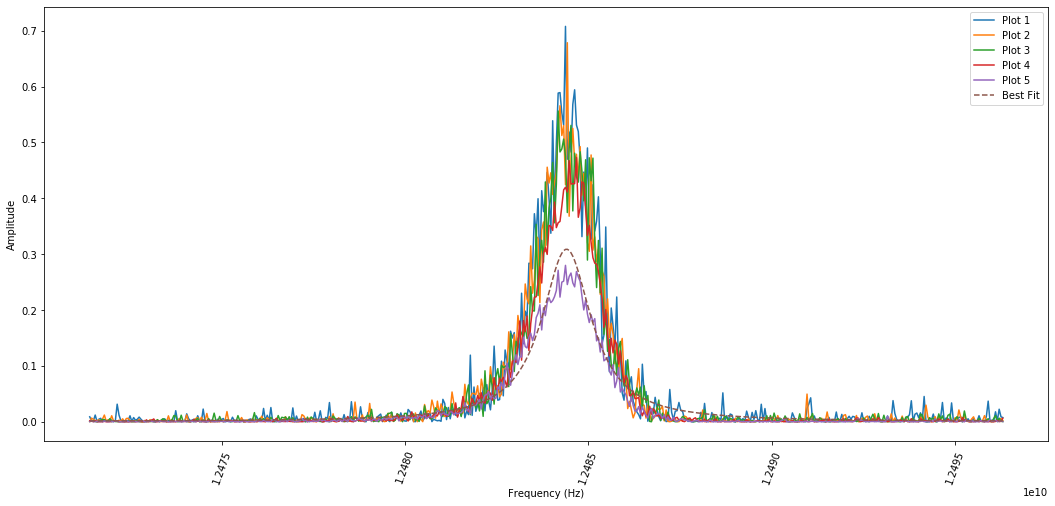

In [61]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


# this function is the curve we wish to fit
# along with its relevant parameters
def gaussian(x, a, x0, sigma):
    """
    a is the amplitude
    x0 is the mean
    sigma is the standard deviation
    """
    return a * np.exp(-(x-x0)**2/(2*sigma**2))

def lorentzian( x, a, x0, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)


def graph(filename, name):

    # load the data
    df = pd.read_csv(filename, header=None, skiprows=[0])
    df = df.to_numpy()

    X = df[:, 0]
    Y = df[:, 1:]**2

    # plot the raw data
    fig, ax = plt.subplots(figsize=(18, 8))

    for col in range(Y.shape[1]):

        # columns to skip
        if col+1 in [6, 7, 8]:
            continue

        print(f"Plotting column {col+1}...", end='\r')
        ax.plot(X, Y[:, col], label=f"Plot {col+1}")

    # produce a guess for your parameters
    # NOTE manual guesses are better!
    # curve_fit will then fine tune the values
    mean = 1.2484e10
    std = 1.5e5
    
#     max_y = np.max(Y)  # Find the maximum y value
#     xs = [x for x in range(20) if Y[x] > max_y/2.0]
#     print (min(xs), max(xs)) # Print the points at half-maximum

    
    # lorentzian best fit
    Y_hat = np.mean(Y, axis=1)

    # NOTE check out the documentation for curve_fit, its helpful
    opt, _ = curve_fit(lorentzian, X, Y_hat, p0=[1, mean, std])

    print("\nOptimal parameters:", opt)

    # plot the best fit
    ax.plot(X, lorentzian(X, *opt), label=f"Best Fit", linestyle='--')

    # graph labelling
    plt.legend()
    plt.xticks(rotation=70)

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")

    plt.savefig(f"{name}.png")
    print("Done!")


if __name__ == "__main__":
    graph("Qubit data(amplitude).csv", name="Amplitudes")


In [30]:
df = pd.read_csv("Qubit data(amplitude).csv", header=None, skiprows=[0])
df = df.to_numpy()
X = df[:, 0]
Y = df[:, 1:]**2
ynorm = Y / Y.max() * 100

def smooth(Y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(Y, box, mode='same')
    return y_smooth

ynorm = smooth(Y, 20)
    
from scipy.interpolate import UnivariateSpline
spline = UnivariateSpline(X,ynorm-50,s=0)
fwhm = abs(spline.roots()[1]-spline.roots()[0])


ValueError: object too deep for desired array

Plotting column 5...
Optimal parameters: [2.81420142e-01 1.24843882e+10 8.88671824e+05]
Done!


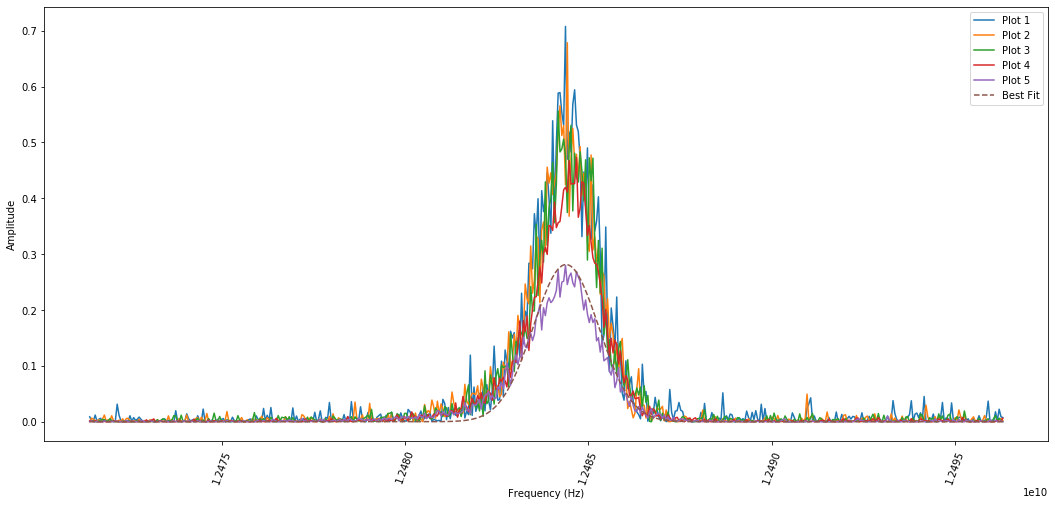

In [60]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


# this function is the curve we wish to fit
# along with its relevant parameters
def gaussian(x, a, x0, sigma):
    """
    a is the amplitude
    x0 is the mean
    sigma is the standard deviation
    """
    return a * np.exp(-(x-x0)**2/(2*sigma**2))

def lorentzian( x, a, x0, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)


def graph(filename, name):

    # load the data
    df = pd.read_csv(filename, header=None, skiprows=[0])
    df = df.to_numpy()

    X = df[:, 0]
    Y = df[:, 1:]**2
    
    # plot the raw data
    fig, ax = plt.subplots(figsize=(18, 8))

    for col in range(Y.shape[1]):

        # columns to skip
        if col+1 in [6, 7, 8]:
            continue

        print(f"Plotting column {col+1}...", end='\r')
        ax.plot(X, Y[:, col], label=f"Plot {col+1}")

    # produce a guess for your parameters
    # NOTE manual guesses are better!
    # curve_fit will then fine tune the values
    mean = 1.2484e10
    std = 1.5e5

    # Gaussian best fit
    Y_hat = np.mean(Y, axis=1)

    # NOTE check out the documentation for curve_fit, its helpful
    opt, _ = curve_fit(gaussian, X, Y_hat, p0=[1, mean, std])

    print("\nOptimal parameters:", opt)

    # plot the best fit
    ax.plot(X, gaussian(X, *opt), label=f"Best Fit", linestyle='--')

    # graph labelling
    plt.legend()
    plt.xticks(rotation=70)

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")

    plt.savefig(f"{name}.png")
    print("Done!")


if __name__ == "__main__":
    graph("Qubit data(amplitude).csv", name="Amplitudes")


In [51]:
#!/usr/bin/env python
# encoding: utf-8

import pyspeckit as p
import matplotlib.pyplot as plt, matplotlib.mlab as mlab
import numpy as np
from scipy.stats import norm
from astropy import log

"""
Calculate the full width at half maximum (FWHM) of an absorption or emission line for a given spectrum using PySpecKit. By: Munazza Alam
Args:
----------
xmin,xmax - the specified interval of the spectrum to plot 
excludemin, excludemax - the specified interval (in wavelength space) of the absorption feature 
n - the number of Monte Carlo iterations 
Returns:
-------
- the mean and standard deviation of the FWHM measured n times
- the spectrum plotted with the the Voigt profile line fit (blue), the pseudo-continuum (yellow), 
and the FWHM (blue)
- a histogram of the FWHM distribution 
"""

def measure_fwhm(filename,xmin,xmax,exclude_min,exclude_max,n):
    vf = p.spectrum.models.inherited_voigtfitter.voigt_fitter()
    
    #read & plot in spectrum 
    sp = p.Spectrum(filename)
    sp.xarr.units = 'micron'
    sp.xarr.xtype = 'wavelength'
    sp.plotter(xmin=xmin, xmax=xmax, ymin=0, errstyle='bars',color='grey')  
    
    #fit pseudocontinuum
    sp.baseline(xmin=xmin, xmax=xmax,exclude=[exclude_min, exclude_max],subtract=False,
                reset_selection=False,hightlight_fitregion=False,order=0)

    #fit voigt profile
    sp.specfit(plot=True, fittype='voigt', color='blue', guesses='moments', 
               vheight=True)

    #measure FWHM
    fwhm = sp.specfit.measure_approximate_fwhm(threshold='error', emission=False, 
                                               interpolate_factor=1024, plot=True, 
                                               grow_threshold=1)
    sp.plotter.refresh()
    fwhm = "{0:0.06f}".format(fwhm)
    fwhm = fwhm[:-7]
    display(fwhm)
    xarr_fit_units = 'microns'
    plt.ylabel('Normalized Flux')
    plt.xlabel('Wavelength ($\mu m$)')
    
 
    #copy flux array for Monte Carlo
    sp.specfit(guesses=sp.specfit.parinfo.values)
    sp2 = sp.copy()
    FWHM = []
    
    #Monte Carlo iterations to estimate uncertainty
    for w in range(n):
        sp2.data = sp.data + np.random.randn(sp.data.size)*sp.error
        sp2.baseline(xmin=xmin, xmax=xmax,exclude=[exclude_min, exclude_max], subtract=False,
                     reset_selection=False, highlight_fitregion=False, order=0)
        sp2.specfit(fittype='voigt', guesses=sp.specfit.parinfo.values)
        dist = sp2.specfit.measure_approximate_fwhm(threshold='error', emission=False,interpolate_factor=1024,grow_threshold=1)
        dist = "{0:0.07f}".format(dist)
        dist = dist[:-7]
        dist = float(dist)
        print (dist)
        FWHM.append(dist)
        
    FWHM = np.array(FWHM)
    FWHM = FWHM*10000
    
    #plot FWHM probability distribution
    plt.figure()
    mu,sigma = norm.fit(FWHM)
    print (mu, sigma)

    n,bins,patches = plt.hist(FWHM,10,normed=True,facecolor='lightblue')
    y = mlab.normpdf(bins,mu,sigma)
    plt.plot(bins,y,'r--',linewidth=2)
    plt.grid(True)
    plt.ylabel('Probability')
    plt.xlabel('FWHM ($\AA$)')
    plt.show()
    
if __name__=="__main__":
    xmin,xmax,exclude_min,exclude_max,n

NameError: name 'xmin' is not defined

Plotting column 5...
Optimal parameters: [4.32654435e-01 1.24842262e+10 1.54709814e+06]
Lower: 12482719128.112963
Upper: 12485890313.273895
Done!


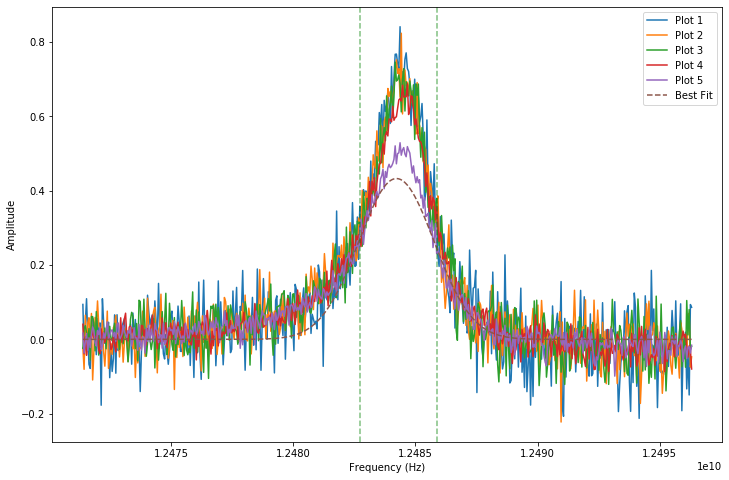

In [5]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline


# this function is the curve we wish to fit
# along with its relevant parameters
def gaussian(x, a, x0, sigma):
    """
    a is the amplitude
    x0 is the mean
    sigma is the standard deviation
    """
    return a * np.exp(-(x-x0)**2/(2*sigma**2))


def graph(filename, name):

    # load the data
    df = pd.read_csv(filename, header=None, skiprows=[0])
    df = df.to_numpy()

    X = df[:, 0]
    Y = df[:, 1:]

    # plot the raw data
    fig, ax = plt.subplots(figsize=(12, 8))

    for col in range(Y.shape[1]):

        # columns to skip
        if col+1 in [6, 7, 8]:
            continue

        print(f"Plotting column {col+1}...", end='\r')
        ax.plot(X, Y[:, col], label=f"Plot {col+1}")

    # produce a guess for your parameters
    # NOTE manual guesses are better!
    # curve_fit will then fine tune the values
    mean = 1.2484e10
    std = 1.5e5

    # Gaussian best fit
    Y_hat = np.mean(Y, axis=1)

    # NOTE check out the documentation for curve_fit, its helpful
    opt, _ = curve_fit(gaussian, X, Y_hat, p0=[1, mean, std])

    print("\nOptimal parameters:", opt)

    # plot the best fit
    ax.plot(X, gaussian(X, *opt), label=f"Best Fit", linestyle='--')

    # FWHM
    S = Y.sum(axis=1)

    spline = UnivariateSpline(X, S-np.max(S)/2, s=0)
    r = spline.roots()  # find the roots
    r1, r2 = r[0], r[-1]
    print(f"Lower: {r1}\nUpper: {r2}")

    plt.axvline(x=r1, color='g', linestyle="--", alpha=0.5)
    plt.axvline(x=r2, color='g', linestyle="--", alpha=0.5)


    # graph labelling
    plt.legend()
    

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")

    plt.savefig(f"{name}.png")
    print("Done!")


if __name__ == "__main__":
    graph("Qubit data(amplitude).csv", name="Amplitudes")


Plotting column 5...
Optimal parameters: [3.08886630e-01 1.24844027e+10 8.28704910e+05]
Lower: 12483413569.269249
Upper: 12485317971.860369
Done!


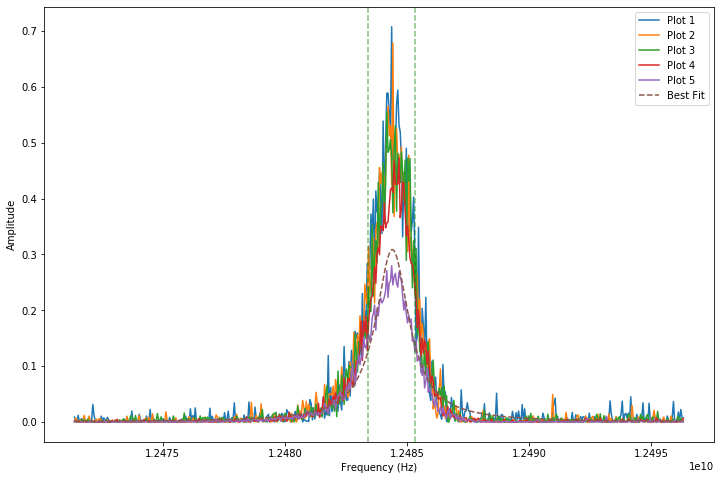

In [6]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline


# this function is the curve we wish to fit
# along with its relevant parameters
def gaussian(x, a, x0, sigma):
    """
    a is the amplitude
    x0 is the mean
    sigma is the standard deviation
    """
    return a * np.exp(-(x-x0)**2/(2*sigma**2))
def lorentzian( x, a, x0, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2)


def graph(filename, name):

    # load the data
    df = pd.read_csv(filename, header=None, skiprows=[0])
    df = df.to_numpy()

    X = df[:, 0]
    Y = df[:, 1:]**2

    # plot the raw data
    fig, ax = plt.subplots(figsize=(12, 8))

    for col in range(Y.shape[1]):

        # columns to skip
        if col+1 in [6, 7, 8]:
            continue

        print(f"Plotting column {col+1}...", end='\r')
        ax.plot(X, Y[:, col], label=f"Plot {col+1}")

    # produce a guess for your parameters
    # NOTE manual guesses are better!
    # curve_fit will then fine tune the values
    mean = 1.2484e10
    std = 1.5e5

    # Gaussian best fit
    Y_hat = np.mean(Y, axis=1)

    # NOTE check out the documentation for curve_fit, its helpful
    opt, _ = curve_fit(lorentzian, X, Y_hat, p0=[1, mean, std])

    print("\nOptimal parameters:", opt)

    # plot the best fit
    ax.plot(X, lorentzian(X, *opt), label=f"Best Fit", linestyle='--')

    # FWHM
    S = Y.sum(axis=1)

    spline = UnivariateSpline(X, S-np.max(S)/2, s=0)
    r = spline.roots()  # find the roots
    r1, r2 = r[0], r[-1]
    print(f"Lower: {r1}\nUpper: {r2}")

    plt.axvline(x=r1, color='g', linestyle="--", alpha=0.5)
    plt.axvline(x=r2, color='g', linestyle="--", alpha=0.5)


    # graph labelling
    plt.legend()
    

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")

    plt.savefig(f"{name}.png")
    print("Done!")


if __name__ == "__main__":
    graph("Qubit data(amplitude).csv", name="Amplitudes")
